In [1]:
import pandas as pd
import  numpy as np
import geopandas as gpd
import joblib
from geojson import Feature, Point, FeatureCollection, Polygon
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

import warnings
import os
os.chdir('/home/jovyan/work/unknown_regions')
warnings.filterwarnings("ignore")

In [16]:
def hexagons_dataframe_to_geojson(df_hex, hex_id_field,geometry_field, value_field,file_output = None):
    list_features = []
    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row[geometry_field],
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)

    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)

    else :
        return feat_collection


def choro_plot(data,cl_name, region):   
    df = data[data['region']==region]
    fname = cl_name

    geojson_obj = (hexagons_dataframe_to_geojson
                    (df,
                     hex_id_field='index',
                     value_field=fname,
                     geometry_field='geometry'))

    fig = (px.choropleth_mapbox(
                        df, 
                        geojson=geojson_obj, 
                        locations='index', 
                        color=fname,
                        color_continuous_scale="Viridis",
                        range_color=(0,df[cl_name].max()),                  
                        mapbox_style='carto-positron',
                        zoom=4,
                        opacity=0.6,
                        labels={'Clusters': fname}))


    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    

    fig.show()

In [20]:
data = pd.read_csv('labelled_region_hexas/all_features_precluster.csv')
data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])
data = gpd.GeoDataFrame(data, geometry='geometry')

In [4]:
feature_columns = [i for i in data.columns if i not in ['index', 'polygon', 'geojson_polygon', 'hex_id', 'geometry', 'region', 'count_2021_2020_diff']]

In [5]:
X = data[feature_columns]
X = X.drop(['num_prisons',
 'num_prisons_5km',
 'num_prisons_10km',
 'num_prisons_30km'], axis=1)


In [ ]:
algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}

In [32]:
db = DBSCAN(eps=3, min_samples=3, metric='euclidean', algorithm='brute').fit(X)
X['dbscan'] = db.labels_
data['dbscan'] = db.labels_

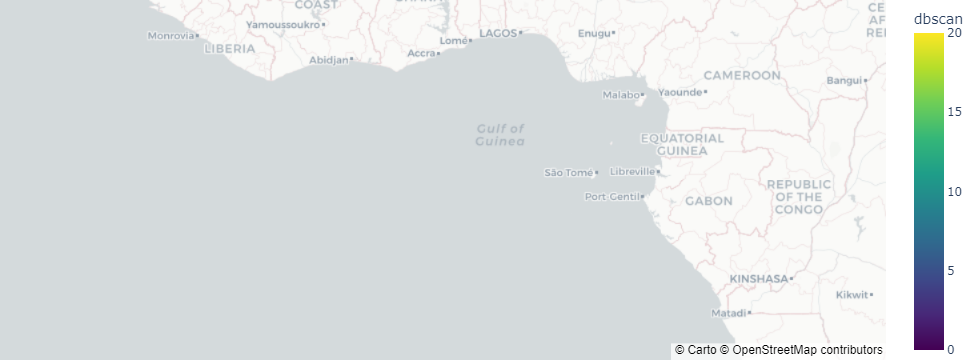

In [33]:
choro_plot(data, 'dbscan', 'sverdlovsk_region')

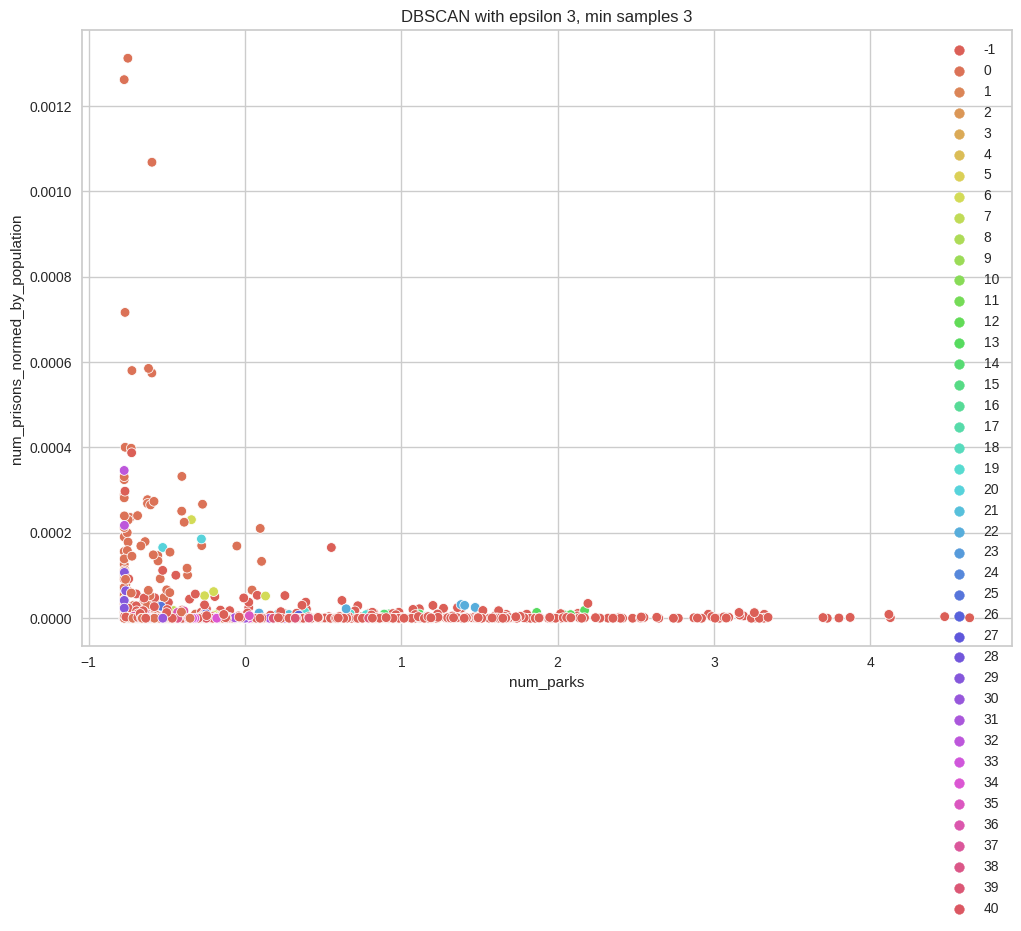

In [34]:
plt.figure(figsize=(12, 8))

ax = sns.scatterplot(X['num_parks'], X['num_prisons_normed_by_population'], hue=db.labels_, 
                palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))

plt.title('DBSCAN with epsilon 3, min samples 3')
plt.show()